In [1]:
!pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
plt.rcParams["figure.figsize"] = (12, 5)

In [4]:
ticker = "SPY"
start = "2015-01-01"
end = None  # None = up to latest available

df = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)

df.head()

Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2015-01-02,170.589630,171.793724,169.551627,171.378523,121465900
2015-01-05,167.508820,169.709381,167.201575,169.543303,169632600
2015-01-06,165.931061,168.339223,165.133869,167.816066,209151400
2015-01-07,167.998749,168.339217,166.811279,167.259691,125346700
2015-01-08,170.979919,171.195832,169.393860,169.410459,147217800


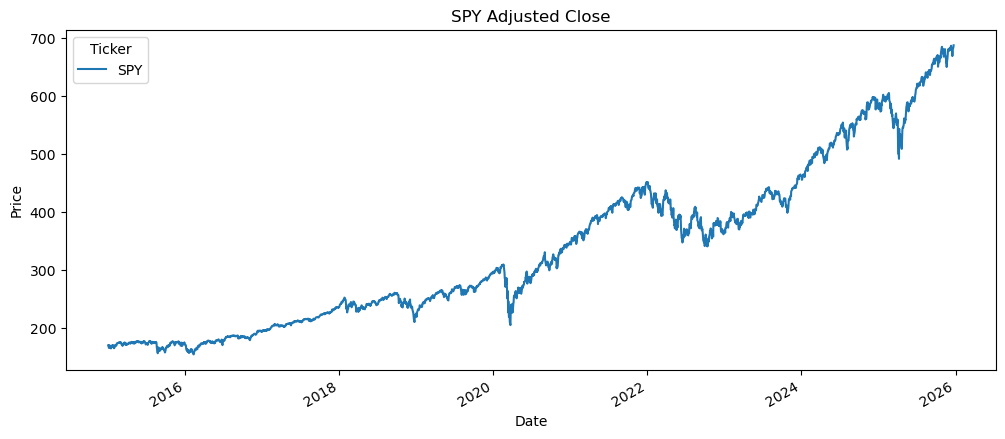

In [5]:
df["Close"].plot()
plt.title(f"{ticker} Adjusted Close")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [6]:
df.columns

MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY')],
           names=['Price', 'Ticker'])

In [7]:
# Flatten columns (keep only price names)
df.columns = df.columns.get_level_values(0)

df.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,170.589630,171.793724,169.551627,171.378523,121465900
2015-01-05,167.508820,169.709381,167.201575,169.543303,169632600
2015-01-06,165.931061,168.339223,165.133869,167.816066,209151400
2015-01-07,167.998749,168.339217,166.811279,167.259691,125346700
2015-01-08,170.979919,171.195832,169.393860,169.410459,147217800


In [8]:
df.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [9]:
# Compute log returns
df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))

# Drop first NaN
df = df.dropna()

df.head()


Price,Close,High,Low,Open,Volume,log_return
Date,,,,,,
2015-01-05,167.508820,169.709381,167.201575,169.543303,169632600,-0.018225
2015-01-06,165.931061,168.339223,165.133869,167.816066,209151400,-0.009464
2015-01-07,167.998749,168.339217,166.811279,167.259691,125346700,0.012384
2015-01-08,170.979919,171.195832,169.393860,169.410459,147217800,0.017590
2015-01-09,169.609711,171.411683,168.995208,171.395071,158567300,-0.008046


In [10]:
df["log_return"].describe()

count    2760.000000
mean        0.000505
std         0.011241
min        -0.115887
25%        -0.003711
50%         0.000653
75%         0.005912
max         0.099863
Name: log_return, dtype: float64

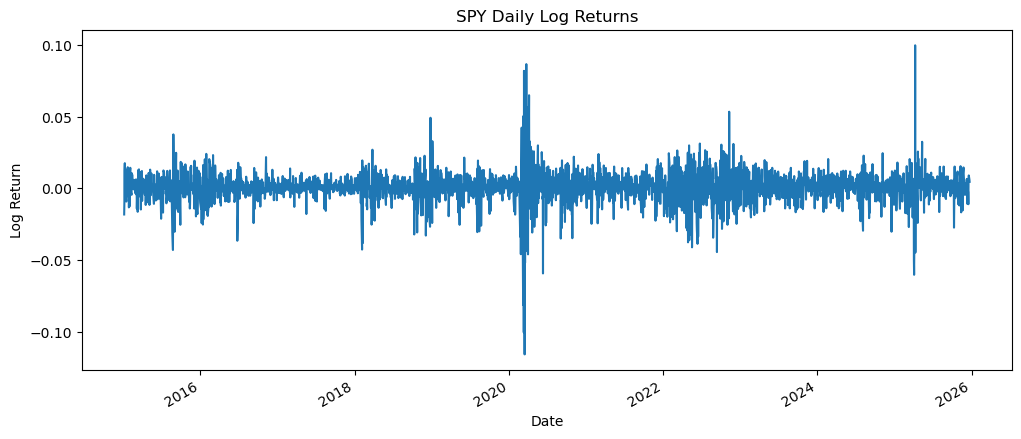

In [11]:
df["log_return"].plot()
plt.title("SPY Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()


In [12]:
TRADING_DAYS = 252

for window in [20, 60, 120]:
    df[f"vol_{window}d"] = (
        df["log_return"]
        .rolling(window)
        .std()
        * np.sqrt(TRADING_DAYS)
    )

df[["vol_20d", "vol_60d", "vol_120d"]].tail()


Price,vol_20d,vol_60d,vol_120d
Date,,,
2025-12-17,0.118631,0.127354,0.109580
2025-12-18,0.120561,0.128025,0.109866
2025-12-19,0.106879,0.128798,0.110500
2025-12-22,0.104133,0.128886,0.110646
2025-12-23,0.093660,0.129063,0.110309


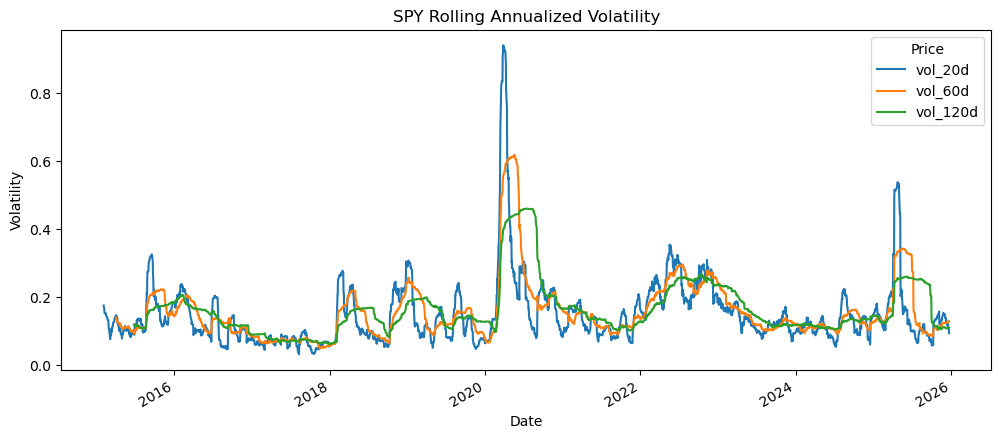

In [13]:
df[["vol_20d", "vol_60d", "vol_120d"]].plot()
plt.title("SPY Rolling Annualized Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.show()


In [14]:
df[["vol_20d", "vol_60d", "vol_120d"]].describe()


Price,vol_20d,vol_60d,vol_120d
count,2741.000000,2701.000000,2641.000000
mean,0.149172,0.156328,0.162924
std,0.100059,0.088884,0.078512
min,0.031859,0.049786,0.062658
25%,0.090815,0.105247,0.116081
50%,0.122468,0.131034,0.137918
75%,0.182774,0.183258,0.186109
max,0.939241,0.617907,0.460177


## Observations: Rolling Historical Volatility (SPY)

### Volatility is clearly time-varying rather than constant.
The rolling volatility estimates fluctuate significantly over time, with extended periods of low volatility followed by sharp spikes during market stress. This confirms that assuming a single, constant volatility for an asset is unrealistic.

### Shorter rolling windows react faster but are significantly noisier.
The 20-day rolling volatility responds almost immediately to large price moves, producing sharp spikes during sudden market shocks. However, it also exhibits high variability and frequent reversals, making it less stable as a risk estimate.

### Longer rolling windows are smoother but lag during regime changes.
The 60-day and especially the 120-day rolling volatility measures evolve more smoothly over time. While this improves stability, these longer windows react more slowly to sudden increases in market uncertainty, underestimating risk immediately after shocks.

### There is a clear trade-off between responsiveness and stability.
The comparison across 20-, 60-, and 120-day windows highlights that no single rolling window is universally optimal. Short windows capture recent information quickly but amplify noise, whereas long windows reduce noise but delay recognition of new volatility regimes.

### Extreme volatility spikes coincide with known market stress events.
The highest volatility levels occur during major market disruptions, such as crisis periods, where short-window volatility briefly exceeds 50–90% annualized. These spikes are progressively dampened as the window length increases.

### Baseline volatility levels are consistent during calm periods.
During stable market conditions, rolling volatility across all window lengths converges to a relatively narrow range (approximately 10–15% annualized), suggesting persistent low-risk regimes in extended bull markets.

### Rolling volatility implicitly assumes equal weighting of past returns.
All rolling estimators treat returns within the window equally, regardless of recency. This motivates the need for alternative estimators that emphasize recent information more heavily, especially during periods of rapid market transitions.

In [15]:
TRADING_DAYS = 252
lam = 0.94  # RiskMetrics default for daily data

# r_t^2
df["ret2"] = df["log_return"] ** 2

# EWMA variance: sigma_t^2 = (1-lam)*r_t^2 + lam*sigma_{t-1}^2
df["ewma_var"] = df["ret2"].ewm(alpha=(1 - lam), adjust=False).mean()

# Convert variance -> volatility, and annualize
df["vol_ewma"] = np.sqrt(df["ewma_var"]) * np.sqrt(TRADING_DAYS)

df[["vol_20d", "vol_60d", "vol_120d", "vol_ewma"]].tail()


Price,vol_20d,vol_60d,vol_120d,vol_ewma
Date,,,,
2025-12-17,0.118631,0.127354,0.109580,0.116391
2025-12-18,0.120561,0.128025,0.109866,0.116575
2025-12-19,0.106879,0.128798,0.110500,0.118344
2025-12-22,0.104133,0.128886,0.110646,0.117252
2025-12-23,0.093660,0.129063,0.110309,0.115055


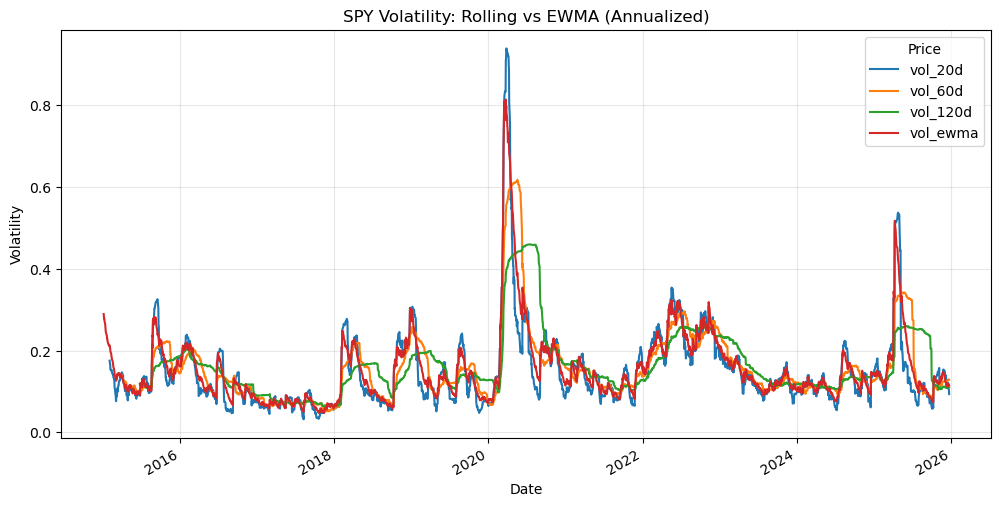

In [16]:
cols = ["vol_20d", "vol_60d", "vol_120d", "vol_ewma"]
df[cols].plot(figsize=(12, 6))
plt.title("SPY Volatility: Rolling vs EWMA (Annualized)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid(True, alpha=0.3)
plt.show()


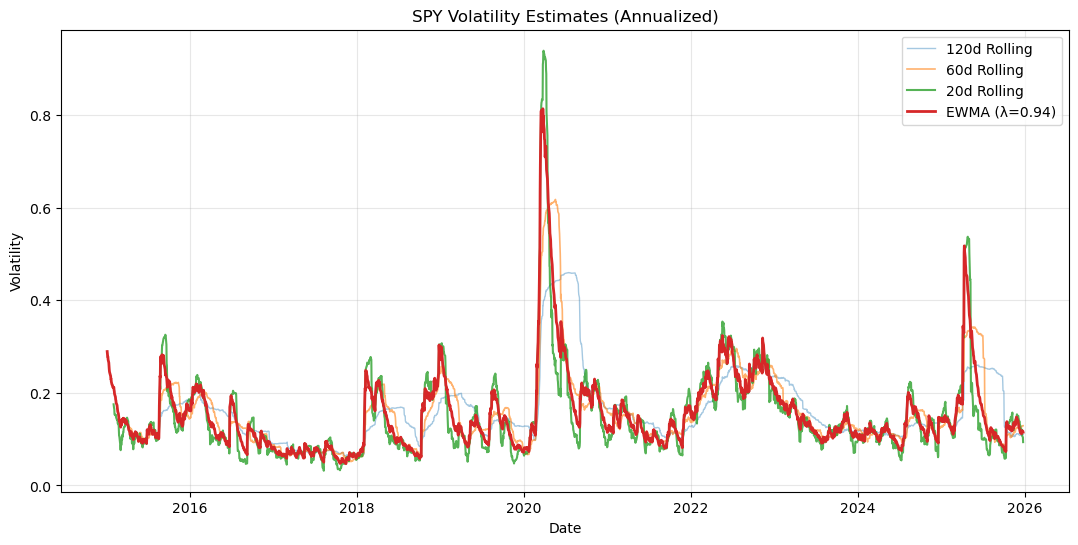

In [17]:
plt.figure(figsize=(13,6))

plt.plot(df.index, df["vol_120d"], label="120d Rolling", alpha=0.4, linewidth=1)
plt.plot(df.index, df["vol_60d"],  label="60d Rolling",  alpha=0.6, linewidth=1.2)
plt.plot(df.index, df["vol_20d"],  label="20d Rolling",  alpha=0.8, linewidth=1.5)
plt.plot(df.index, df["vol_ewma"], label="EWMA (λ=0.94)", linewidth=2)

plt.title("SPY Volatility Estimates (Annualized)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


All volatility estimators capture the same broad risk regimes, with clear spikes during market stress and prolonged low-volatility periods during calm markets.

Shorter rolling windows respond faster to shocks but are significantly noisier, while longer windows provide smoother but lagging risk estimates.

EWMA volatility balances responsiveness and stability, generally tracking between short- and long-window rolling volatility.

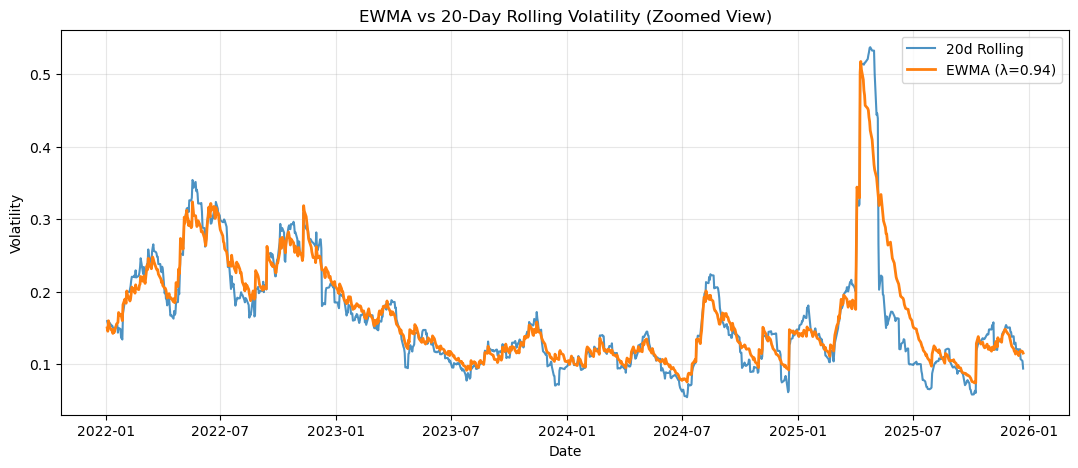

In [18]:
zoom_df = df.loc["2022-01-01":]

plt.figure(figsize=(13,5))
plt.plot(zoom_df.index, zoom_df["vol_20d"], label="20d Rolling", alpha=0.8)
plt.plot(zoom_df.index, zoom_df["vol_ewma"], label="EWMA (λ=0.94)", linewidth=2)

plt.title("EWMA vs 20-Day Rolling Volatility (Zoomed View)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


EWMA reacts more smoothly to sudden changes in market conditions compared to the abrupt jumps observed in 20-day rolling volatility.

During volatility decay phases, EWMA remains elevated longer, while rolling volatility can drop sharply once large returns exit the window.

The differences between the two estimators are most pronounced around market turning points and regime transitions.

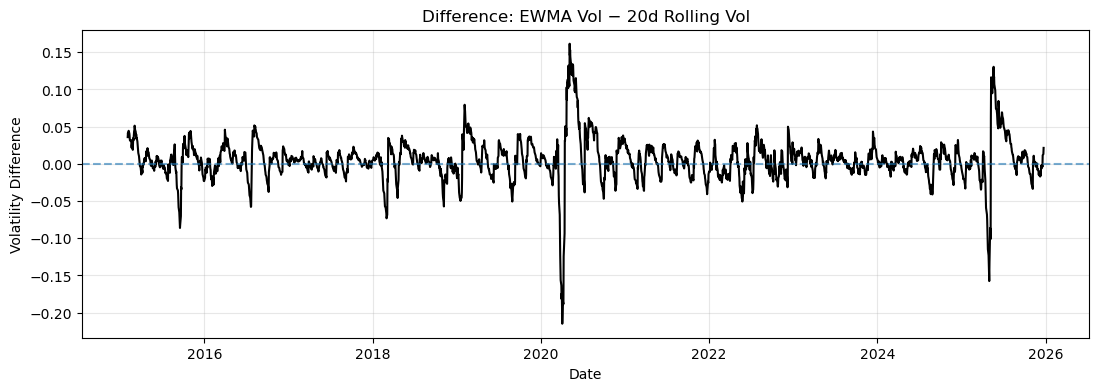

In [19]:
plt.figure(figsize=(13,4))
plt.plot(df.index, df["vol_ewma"] - df["vol_20d"], color="black")
plt.axhline(0, linestyle="--", alpha=0.6)

plt.title("Difference: EWMA Vol − 20d Rolling Vol")
plt.xlabel("Date")
plt.ylabel("Volatility Difference")
plt.grid(alpha=0.3)
plt.show()


The difference oscillates around zero during stable periods, indicating broad agreement between the two estimators.

Large positive or negative deviations occur primarily during market stress and volatility regime transitions.

Sign reversals in the difference highlight moments when risk perception shifts rapidly, emphasizing estimator sensitivity during shocks.

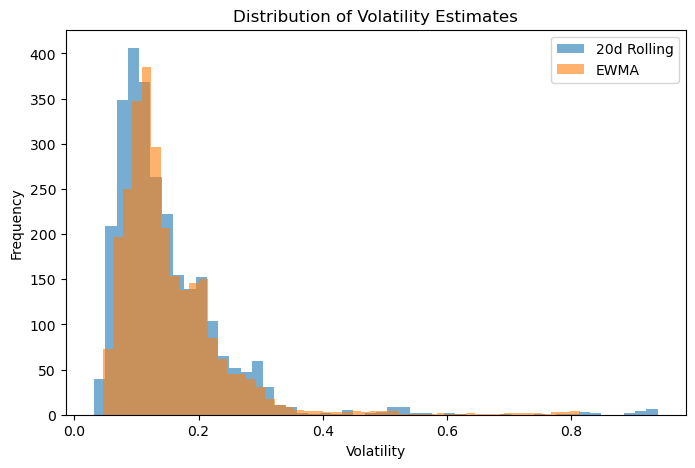

In [20]:
plt.figure(figsize=(8,5))
plt.hist(df["vol_20d"].dropna(), bins=50, alpha=0.6, label="20d Rolling")
plt.hist(df["vol_ewma"].dropna(), bins=50, alpha=0.6, label="EWMA")

plt.title("Distribution of Volatility Estimates")
plt.xlabel("Volatility")
plt.ylabel("Frequency")
plt.legend()
plt.show()


EWMA volatility exhibits a tighter distribution, reflecting smoother behavior and reduced sensitivity to short-term noise.

Rolling 20-day volatility shows heavier tails, driven by sharp reactions to isolated large returns.

The distributional differences reinforce the trade-off between stability (EWMA) and reactivity (rolling volatility).

## Observations: EWMA Volatility (SPY)

### EWMA volatility responds more smoothly to changes in market conditions than rolling windows.
Unlike rolling volatility, which can change abruptly when large returns enter or exit the window, EWMA updates volatility gradually by exponentially decaying past information.

### EWMA reacts faster to changes in volatility than longer rolling windows.
Compared to 60-day and 120-day rolling volatility, EWMA reflects recent shifts in market uncertainty more quickly, as recent returns receive higher weight.

### EWMA is less noisy than short rolling windows.
While 20-day rolling volatility can fluctuate sharply in response to short-term noise, EWMA produces a smoother volatility estimate that avoids overreacting to isolated daily moves.

### EWMA often lies between short- and long-window rolling volatility estimates.
In stable market conditions, EWMA volatility typically falls between 20-day and 60-day rolling volatility levels, reflecting a balance between responsiveness and stability.

### EWMA provides a more realistic risk estimate during volatility transitions.
During periods where markets transition from high- to low-volatility regimes (or vice versa), EWMA avoids sudden drops or jumps, making it better suited for risk management and position sizing.